## Importing Data Notebook and Inputting User Metadata

Code sources:
- https://github.com/dlab-berkeley/Geospatial-Fundamentals-in-Python/blob/master/Geopandas_Intro_F2019_GC.ipynb
- https://rasterio.readthedocs.io/en/stable/

#### Metadata: operating system and directory

Specify operating system:

In [401]:
# get operating system (Windows or Mac) from user
op_user_input = input("What is your operating system?\nEnter w for Windows and m for Mac.")


What is your operating system?
Enter w for Windows and m for Mac.m


In [402]:
# set operating system for workflow
op_system_dict = {'w':'Windows', 'm':'Mac'}
op_system = op_system_dict[op_user_input]
op_system

'Mac'

Set path to master directory:

In [403]:
# Set the object `master` to your local file path of the master folder
# master = 'C:/Users/theaa/Desktop/Data Science Pedagogy Resources/Python/Human_Mobility_Project/Human_Mobility_Project'
master = '/Users/katewetstone/Desktop/CYPLAN 257 Data Science Human Mobility/Human_Mobility_Project'

In [404]:
user_ans = input('Is this the correct master directory? Type Y or N\n'+master)

Is this the correct master directory? Type Y or N
/Users/katewetstone/Desktop/CYPLAN 257 Data Science Human Mobility/Human_Mobility_ProjectY


In [405]:
if user_ans == 'N':
    master = input('Enter the correct path to the master directory')

#### Metadata: PCA datasets and files

Input metadata about datasets to be used in PCA. Specify the list of PCA datasets to be used and the direction of vulnerability for each in the form of a dictionary. Dictionary format: `{'dataset_zipfile_name':direction of vulnerability}`

For direction of vulnerability
- 1: higher value indicates higher vulnerability (eg. infant mortality)
- -1: lower value indicates higher vulnerability (eg. median income)

To get the direction of vulnerability for a given dataset:
`pca_data_metadata['pca_data_name']` (eg. `pca_data_metadata['travel_time']` returns 1)

In [406]:
pca_data_metadata = {'travel_time':1,
#                     'infant_mort':1,
                    'val_prod':-1,
                    'val_prod_per_ha':-1,
                    'night_lights':-1}
pca_data_names = list(pca_data_metadata.keys())

print(pca_data_metadata)
print(pca_data_names)

{'travel_time': 1, 'val_prod': -1, 'val_prod_per_ha': -1, 'night_lights': -1}
['travel_time', 'val_prod', 'val_prod_per_ha', 'night_lights']


Enter a list of zipfile names containing the data required for pca and for country borders:

In [407]:
myfiles = ('TravelTime_50k.zip', 
           'World_Country_Borders.zip', 
#            'PovMap_Global_Infant_Mortality.zip', 
           'val_prod.zip',
           'Black_Marble_SA_Reduced.zip')

### Installing and Importing Necessary Packages

Geopandas works for vector data. For raster data, use rasterio (see next section).

In [390]:
# !ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" < /dev/null 2> /dev/null

Install libraries:

In [408]:
# get list of installed packages
import pip
installed_pkgs = !pip list --format freeze
installed_pkgs = [pkg.split('==')[0] for pkg in installed_pkgs]

In [409]:
# install any required packages that are not already installed
required_pkgs = ['wget','pysal','mapclassify','geopy','seaborn',
                'Fiona','Shapely','pyproj','spatialindex','Rtree',
                'geopandas','descartes','affine','mercantile']
if op_system == 'Windows':
    required_pkgs.insert(0,'os')
    required_pkgs.insert(0,'zipfile')
if op_system == 'Mac':
    required_pkgs.append('rasterio')

from pip._internal import main as pip
already_installed = []
for pkg in required_pkgs:
    if pkg not in installed_pkgs:
        pip.main(['install','--user',pkg])
    else:
        already_installed.append(pkg)

print('Required packages that were already installed:',
      already_installed)

ERROR: Could not find a version that satisfies the requirement spatialindex (from versions: none)
ERROR: No matching distribution found for spatialindex


Required packages that were already installed: ['wget', 'pysal', 'mapclassify', 'geopy', 'seaborn', 'Fiona', 'Shapely', 'pyproj', 'Rtree', 'geopandas', 'descartes', 'affine', 'mercantile', 'rasterio']


Import libraries:

In [410]:
from __future__ import division

# Import os and zipfile for Windows
import os
import zipfile

# Import wget    
import wget

# geopandas dependencies
import pandas as pd
import fiona 
import shapely
import pyproj
import rtree

# Import geopandas, mapclassify, and matplotlib
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import mapping

# import packages necessary besides geopandas and rasterio
from random import randint
import numpy as np
import math
import warnings
import sklearn
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl
from descartes import PolygonPatch
import geopy.distance
import seaborn as sns

### Importing Rasterio

References: 
- https://rasterio.readthedocs.io/en/stable/
- https://rasterio.readthedocs.io/en/stable/quickstart.html#reading-raster-data

In [412]:
if op_system == 'Windows' :
    !conda config --add channels conda-forge
    !conda install rasterio

In [414]:
import rasterio
import rasterio.features
import rasterio.warp
import rasterio.mask
import rasterio.plot
from rasterio.enums import Resampling
from rasterio.vrt import WarpedVRT
from rasterio.crs import CRS
from rasterio import shutil as rio_shutil

import affine
from affine import Affine
import mercantile

## Fetch and Unzip Raw Data

Fetch data files with `wget`

In [415]:
# Set our current directory to the master folder
os.chdir(master)

See the list saved as `myfiles` in the metadata section:

In [416]:
myfiles

('TravelTime_50k.zip',
 'World_Country_Borders.zip',
 'val_prod.zip',
 'Black_Marble_SA_Reduced.zip')

In [417]:
data_path = 'data/raw_data'

In [418]:
prefix = 'https://github.com/AaronScherf/Southern_Africa_Data/blob/master/'

for f in myfiles:
    wget.download(prefix+f+'?raw=true', out = data_path)

Unzip the data files

In [419]:
for f in myfiles:
    with zipfile.ZipFile(data_path+'/'+f, 'r') as zip_ref:
        zip_ref.extractall(data_path)

In [420]:
if 'CELL5M.zip' in myfiles:
    dir_name = master + '/' + data_path + '/CELL5M/Raster'
    extension = ".zip"

    os.chdir(dir_name) # change directory from working dir to dir with files

    for item in os.listdir(dir_name): # loop through items in dir
        if item.endswith(extension): # check for ".zip" extension
            file_name = os.path.abspath(item) # get full path of files
            zip_ref = zipfile.ZipFile(file_name) # create zipfile object
            zip_ref.extractall(dir_name) # extract file to dir
            zip_ref.close() # close file
            os.remove(file_name) # delete zipped file

In [421]:
# Set our current directory to the master folder
os.chdir(master)

## Reading in Vector Data with GeoPandas

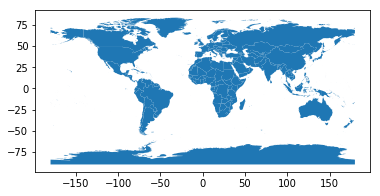

In [422]:
# read in borders shapefile
country_borders = gpd.read_file(data_path+'/'+
                                'World_Country_Borders/ne_50m_admin_0_countries.shp') 
# visualize country borders
country_borders.plot()

In [423]:
print("Country Borders CRS", country_borders.crs)

Country Borders CRS {'init': 'epsg:4326'}


In [424]:
southern_africa_countries = ('South Africa', 
                             'Angola', 
                             'Botswana',
                             'Lesotho',
                             'eSwatini',
                             'Namibia',
                             'United Republic of Tanzania',
                             'Zambia',
                             'Zimbabwe',
                             'Madagascar',
                             'Democratic Republic of the Congo',
                             'Mozambique',
                             'Malawi'
                            )

sum(country_borders['ADMIN'].isin(southern_africa_countries)) == len(southern_africa_countries)

True

In [425]:
southern_africa_borders = country_borders[country_borders['ADMIN'].isin(southern_africa_countries)]

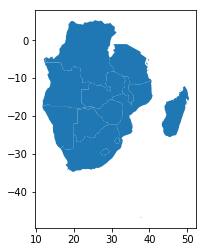

In [426]:
southern_africa_borders.plot()

In [427]:
if op_system == 'Windows':
    # FLAG: aaron, check that this displays the same way within an if 
#     statement. also check command three chunks down
    southern_africa_borders.unary_union.envelope
elif op_system == 'Mac':
    print(southern_africa_borders.bounds)

          minx       miny       maxx       maxy
0    25.224023 -22.402051  33.006738 -15.643066
1    21.978906 -18.041504  33.661523  -8.193652
43   29.323438 -11.716211  40.463574  -0.994922
49   30.787500 -27.309961  32.112891 -25.742969
56   16.447559 -46.962891  37.887695 -22.146289
101  11.721680 -28.938770  25.258789 -16.967676
102  30.221777 -26.861621  40.844531 -10.464355
116  32.670410 -17.131055  35.892773  -9.395020
117  43.257129 -25.570508  50.482715 -12.079590
124  27.051758 -30.642285  29.390723 -28.581738
191  12.213672 -13.453809  31.274023   5.312109
211  19.977344 -26.854199  29.364844 -17.787598
233  11.743066 -18.019727  24.046680  -4.428906


In [428]:
max_lat = max(southern_africa_borders.bounds['maxx']) # right bound
min_lat = min(southern_africa_borders.bounds['minx']) # left bound
max_long = max(southern_africa_borders.bounds['maxy']) # top bound
min_long = min(southern_africa_borders.bounds['miny']) # bottom bound

In [429]:
upper_left = [min_lat,max_long]
upper_right = [max_lat,max_long]
lower_right = [max_lat,min_long]
lower_left = [min_lat,min_long]

In [430]:
if op_system == 'Windows':
    southern_africa_borders.unary_union[1] | southern_africa_borders.unary_union[7]

In [431]:
if op_system == 'Mac':
    southern_africa_box = shapely.geometry.box(
        min_lat, min_long, max_lat, max_long, ccw=True)
elif op_system == 'Windows':
    southern_africa_box = southern_africa_borders.unary_union.envelope

In [432]:
# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile of the boundary box
with fiona.open('data/raw_data/border_box.shp', 'w', 'ESRI Shapefile', schema) as c:
  ## If there are multiple geometries, put the \"for\" loop here\n",
    c.write({
        'geometry': mapping(southern_africa_box),
        'properties': {'id': 123},
    })

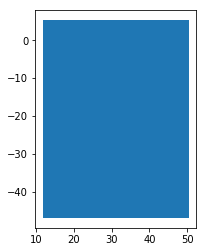

In [433]:
# read in borders shapefile
border_box = gpd.read_file(data_path+'/'+
                                'border_box.shp') 
# visualize country borders
border_box.plot()

## Read in Raster Data with Rasterio

Read in the data for variables to use in the principal component analysis.

In [434]:
# display list of datasets
pca_data_names

['travel_time', 'val_prod', 'val_prod_per_ha', 'night_lights']

In [435]:
# Save paths for all datasets
# FLAG: turn into a for loop once the names of paths matches 
#                   what we want them to be saved as
Paths = list()
Paths.append(data_path+'/'+'TravelTime_50k/Traveltime_50k.tif')
# Paths.append(data_path+'/'+
#             'PovMap_Global_Infant_Mortality/povmap_global_subnational_infant_mortality_rates_v2.tif')
Paths.append(data_path+'/'+'val_prod.tif')
Paths.append(data_path+'/'+'val_prod_per_ha.tif')
Paths.append(data_path+'/'+'Black_Marble_SA_Reduced.tif')

# Create a dataframe to store pca data through pipeline
pca_data = pd.DataFrame({'path':Paths},
                       index = pca_data_names)
pca_data

,path
travel_time,data/raw_data/TravelTime_50k/Traveltime_50k.tif
val_prod,data/raw_data/val_prod.tif
val_prod_per_ha,data/raw_data/val_prod_per_ha.tif
night_lights,data/raw_data/Black_Marble_SA_Reduced.tif


In [436]:
# Create a list with raster data
rasters = list()
for name in pca_data_names:
    rasters.append(rasterio.open(pca_data.loc[name,'path']))

# add as a column to the pca dataframe
pca_data['raster'] = rasters

# To access one raster data file
pca_data.loc['travel_time','raster']

<open DatasetReader name='data/raw_data/TravelTime_50k/Traveltime_50k.tif' mode='r'>

In [437]:
# Create a list with raster metadata
metadata = list()
for name in pca_data_names:
    metadata.append(pca_data.loc[name,'raster'].profile)
    
# add as a column to pca dataframe
pca_data['metadata'] = metadata

# To access one raster metadata file
pca_data.loc['travel_time','metadata']

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 828, 'height': 742, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333333333329998, 0.0, -17.499999999666578,
       0.0, -0.0833333333333, 26.9999999998646), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}

travel_time


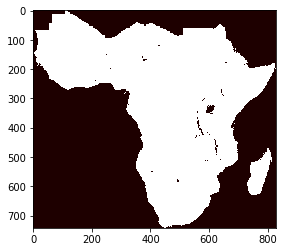

val_prod


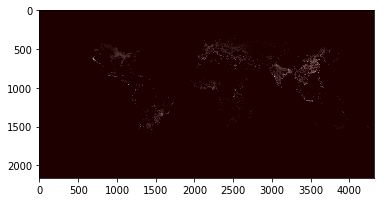

val_prod_per_ha


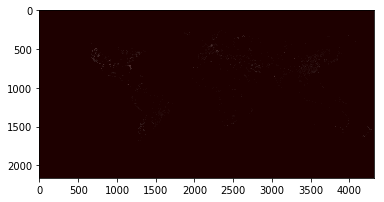

night_lights


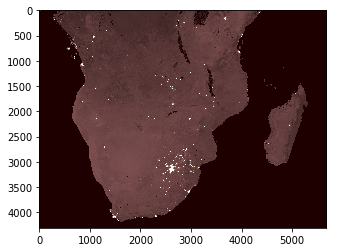

In [438]:
for name in pca_data_names:
    print(name)
    pyplot.imshow(pca_data.loc[name,'raster'].read(1), cmap='pink')
    pyplot.savefig(name+'_raw.png')
    pyplot.show()

All datasets for PCA should use the same coordinate reference system, `EPSG:4326`.

In [439]:
def check_crs(datasets, crs='EPSG:4326'):
    # Checks that all datasets use the same coordinate reference system
    # Returns true if all datasets use the crs specified
    check = True
    for dataset in datasets:
        if dataset.crs != crs:
            print(dataset.name)
            print(dataset.crs)
            check = False
    return check

check_crs(pca_data['raster'])

True

In [440]:
vprasterdf = pd.DataFrame(pca_data.loc['val_prod','raster'].read(1))
vprasterdf.head()


,0,1,2,3,4,5,6,7,8,9,...,4310,4311,4312,4313,4314,4315,4316,4317,4318,4319
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Warping Rasters into the Same Resolution and CRS

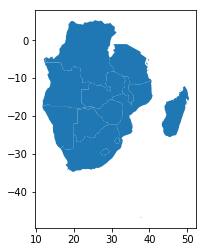

In [448]:
southern_africa_borders.plot()

In [449]:
bounds = list()
for name in pca_data_names:
    bounds.append(list(pca_data.loc[name,'raster'].bounds))
bounds.append(list(border_box.bounds.iloc[0,:]))
bounds = pd.DataFrame(bounds, columns = ('minx','miny','maxx','maxy'))
bounds

,minx,miny,maxx,maxy
0,-17.500000,-34.833333,51.500000,27.000000
1,-180.000000,-89.999280,179.998560,90.000000
2,-180.000000,-89.999280,179.998560,90.000000
3,6.279167,-35.812500,53.637500,0.062500
4,11.721680,-46.962891,50.482715,5.312109


In [450]:
# Find the intersection of all raster and boundary files
# NOTE: May not work in other hemisphere quadrants
inter_bounds = (bounds.iloc[:,0].max(),
                bounds.iloc[:,1].max(),
                bounds.iloc[:,2].min(),
                bounds.iloc[:,3].min())
inter_bounds

(11.7216796875, -34.833333333443996, 50.48271484375002, 0.0625)

In [451]:
input_files = (pca_data['path'])

# Destination CRS
dst_crs = CRS.from_epsg(4326)

# These coordiantes are in Web Mercator
dst_bounds = inter_bounds

# Output image dimensions

bottom_left = (inter_bounds[0], inter_bounds[1]) 
bottom_right = (inter_bounds[2], inter_bounds[1])

dst_width = geopy.distance.distance(bottom_left, bottom_right).km

top_left = (inter_bounds[0],inter_bounds[3])

dst_height = geopy.distance.distance(top_left, bottom_left).km

print(dst_width, dst_height)

# Output image transform
left, bottom, right, top = dst_bounds
xres = (right - left) / dst_width
yres = (top - bottom) / dst_height
dst_transform = affine.Affine(xres, 0.0, left,
                              0.0, -yres, top)

vrt_options = {
    'resampling': Resampling.cubic,
    'crs': dst_crs,
    'transform': dst_transform,
    'height': dst_height,
    'width': dst_width,
}

for path in input_files:

    with rasterio.open(path) as src:

        with WarpedVRT(src, **vrt_options) as vrt:

            # At this point 'vrt' is a full dataset with dimensions,
            # CRS, and spatial extent matching 'vrt_options'.

            # Read all data into memory.
            data = vrt.read()

            # Process the dataset in chunks.  Likely not very efficient.
            for _, window in vrt.block_windows():
                data = vrt.read(window=window)

            # Dump the aligned data into a new file.  A VRT representing
            # this transformation can also be produced by switching
            # to the VRT driver.
            directory, name = os.path.split(path)
            outfile = os.path.join(directory, 'aligned_{}'.format(name))
            rio_shutil.copy(vrt, outfile, driver='GTiff')

4298.244862722446 3801.5866129953497


In [452]:
for file in pca_data_names:
    directory, name = os.path.split(pca_data.loc[file,'path'])
    pca_data.loc[file,'aligned_path'] = os.path.join(directory, 'aligned_{}'.format(name))

In [453]:
# Create a list with raster data
al_rasters = list()
for name in pca_data_names:
    al_rasters.append(rasterio.open(pca_data.loc[name,'aligned_path']))

# add as a column to the pca dataframe
pca_data['al_raster'] = al_rasters

pca_data.loc['travel_time','al_raster']

<open DatasetReader name='data/raw_data/TravelTime_50k/aligned_Traveltime_50k.tif' mode='r'>

In [454]:
for name in pca_data_names:
    print(pca_data.loc[name,'al_raster'].bounds)

BoundingBox(left=11.7216796875, bottom=-34.82794864767964, right=50.48050670231176, top=0.0625)
BoundingBox(left=11.7216796875, bottom=-34.82794864767964, right=50.48050670231176, top=0.0625)
BoundingBox(left=11.7216796875, bottom=-34.82794864767964, right=50.48050670231176, top=0.0625)
BoundingBox(left=11.7216796875, bottom=-34.82794864767964, right=50.48050670231176, top=0.0625)


In [455]:
# check whether negative values were introduced
vpharasterdf = pd.DataFrame(pca_data.loc['val_prod_per_ha','al_raster'].read(1))
vpravel = vprasterdf.values.ravel()
print(sum(vpravel < 0))
print(sum(vpravel == -1.0))
print(sum((vpravel <0) & (vpravel != -1.0)))

8498296
8498296
0


travel_time


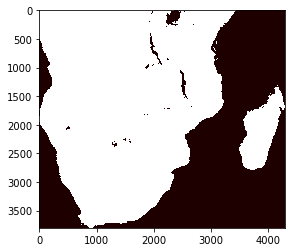

val_prod


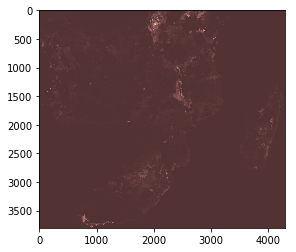

val_prod_per_ha


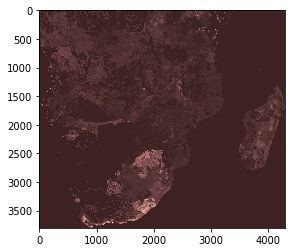

night_lights


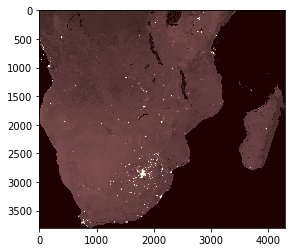

In [456]:
for name in pca_data_names:
    print(name)
    pyplot.imshow(pca_data.loc[name,'al_raster'].read(1), cmap='pink')
    pyplot.savefig(name+'_aligned.png')
    pyplot.show()

### Masking the Outline of Southern Africa from Raster files using Shapefile Boundaries

Code Source: 
Clipping Shapefile Vectors - https://www.earthdatascience.org/courses/earth-analytics-python/spatial-data-vector-shapefiles/clip-vector-data-in-python-geopandas-shapely/

Masking Rasters using Vector Geometry - https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html

In [457]:
# for raster in raster_data_paths:
for raster in pca_data['aligned_path']:

    with fiona.open("data/raw_data/border_box.shp", "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(str(raster[:-4]) + '_mask.tif', "w", **out_meta) as dest:
        dest.write(out_image)

In [458]:
# create list of masked data
Masked = list()
for name in pca_data_names:
    Masked.append(rasterio.open(
        pca_data.loc[name,'aligned_path'][:-4] + '_mask.tif'))

# add column for masked data to dataframe
pca_data['masked'] = Masked

In [459]:
# create list of band data
raster_bands = list()
for name in pca_data_names:
    raster_bands.append(pca_data.loc[name,'masked'].read(1))

# add column for band data to dataframe
pca_data['band'] = raster_bands

In [460]:
# create list of dataframes
raster_dfs = list()
for name in pca_data_names:
    raster_dfs.append(pd.DataFrame(pca_data.loc[name,'band']))

# add column for dfs to pca_data
pca_data['df'] = raster_dfs

In [461]:
# Check that all raster masks have same shape
shapes = list()
for name in pca_data_names:
    shapes.append(list(pca_data.loc[name,'df'].shape))

len(np.unique(shapes)) == 2

True

In [462]:
# Check that top left cell is identical for all transformed rasters
top_left = list()
for name in pca_data_names:
    top_left.append(pca_data.loc[name,'masked'].transform * (0,0))

# Confirm that top left pixel is the same for all rasters
top_left=np.array(top_left)
len(np.unique(top_left)) == 2

True

### Address missing and placeholder values

Use each dataset's README file to standardize treatment of missing and placeholder (ie. ocean) values across datasets. Replace all missing values with NaN.

In [463]:
pca_data.loc['night_lights','metadata']['nodata'] == None

True

In [464]:
def explore_codevals(dataset_name, df):
    df = pca_data.loc[dataset_name,df]
    n = df.size
    form = df.loc[:,1].dtype
    df_mean = df.values.mean()
    df_std = df.values.std(ddof=1)
    min_val = df.min().min()
    max_val = df.max().max()
    count_na = np.count_nonzero(df.isna())
    perc_na = round(100 * count_na / n)
    nodata = pca_data.loc[dataset_name,'metadata']['nodata']
    if nodata == None:
        count_nodata = None
        perc_nodata = None
    else:
        count_nodata = np.count_nonzero(df == nodata)
        perc_nodata = round(100 * count_nodata / n)
    count_neg = np.count_nonzero(df < 0)
    perc_neg = round(100 * count_neg / n)
    count_min = np.count_nonzero(df == min_val)
    perc_min = round(100 * count_min / n)
    
    return pd.DataFrame([[dataset_name, form, n, df_mean, df_std, min_val, max_val, 
                         count_na, perc_na,nodata,count_nodata, perc_nodata,
                          count_neg, perc_neg, count_min, perc_min]],
        columns=['data','format','n','mean', 'std','min','max','count_na', 'perc_na',
                 'nodata_code','count_nodata','perc_nodata',
                 'count_neg','perc_neg','count_min','perc_min'],)

In [465]:
codeval_df = pd.DataFrame()
for name in pca_data_names:
    codeval_df = pd.concat([codeval_df, 
                           explore_codevals(name, 'df')],
                          ignore_index=True)
codeval_df = codeval_df.set_index('data')

In [466]:
codeval_df

,format,n,mean,std,min,max,count_na,perc_na,nodata_code,count_nodata,perc_nodata,count_neg,perc_neg,count_min,perc_min
data,,,,,,,,,,,,,,,
travel_time,float64,16336698,-1.331964e+38,1.660816e+38,-3.402823e+38,5.185215e+01,0,0.0,-3.40282e+38,6394658,39,6394802,39.0,6394658,39.0
val_prod,float32,16336698,1.833798e+05,7.825454e+05,-3.228578e+06,4.961110e+07,0,0.0,-1,10479669,64,10515816,64.0,1,0.0
val_prod_per_ha,float32,16336698,2.642404e+02,6.467990e+02,-5.680455e+02,1.831449e+04,0,0.0,-1,10479669,64,10482950,64.0,1,0.0
night_lights,uint8,16336698,1.444776e+01,1.686410e+01,0.000000e+00,2.550000e+02,0,0.0,None,None,None,0,0.0,6370032,39.0


Explore the negative values that are not equal to the minimum or to the metadata entry for "nodata" 

144


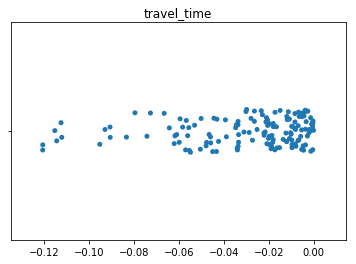

In [467]:
name = 'travel_time'
df = pca_data.loc[name,'df']
nodata = pca_data.loc[name,'metadata']['nodata']
negvals = df.values # .ravel() for 1-d list
negvals = negvals[(negvals < 0) & (negvals != nodata)]
print(len(negvals.ravel()))

# show the values for all entries that aren't the minimum / 
# code entry for no data, but are still negative
sns.stripplot(x=negvals.ravel(), jitter=True);
plt.title(name);

36147
10479669


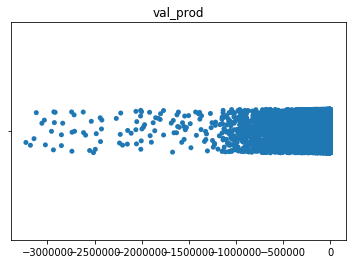

In [468]:
name = 'val_prod'
df = pca_data.loc[name,'df']
nodata = pca_data.loc[name,'metadata']['nodata']
negvals = df.values # .ravel() for 1-d list
negvals = negvals[(negvals < 0) & (negvals != nodata)]
print(len(negvals.ravel())) # right length based on codevals_df
print(len(df.values[df == nodata].ravel()))

# show the values for all entries that aren't the minimum / 
# code entry for no data, but are still negative
sns.stripplot(x=negvals.ravel(), jitter=True);
plt.title(name);

3281
10479669


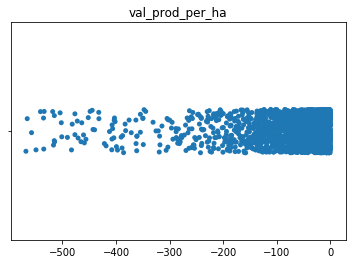

In [469]:
name = 'val_prod_per_ha'
df = pca_data.loc[name,'df']
nodata = pca_data.loc[name,'metadata']['nodata']
negvals = df.values # .ravel() for 1-d list
negvals = negvals[(negvals < 0) & (negvals != nodata)]
print(len(negvals.ravel())) # right length based on codevals_df
print(len(df.values[df == nodata].ravel()))

# show the values for all entries that aren't the minimum / 
# code entry for no data, but are still negative
sns.stripplot(x=negvals.ravel(), jitter=True);
plt.title(name);

In [470]:
for name in pca_data_names:
    print(name)
    print(pca_data.loc[name,'metadata'])

travel_time
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 828, 'height': 742, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333333333329998, 0.0, -17.499999999666578,
       0.0, -0.0833333333333, 26.9999999998646), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}
val_prod
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.083333, 0.0, -180.0,
       0.0, -0.083333, 90.0), 'tiled': False, 'interleave': 'band'}
val_prod_per_ha
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.083333, 0.0, -180.0,
       0.0, -0.083333, 90.0), 'tiled': False, 'interleave': 'band'}
night_lights
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5683, 'height': 4305, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': A

In [472]:
# add column with cleaned dfs
cleaned_dfs = list()

# replace all negative values with 0 and normalize values
for name in pca_data_names:
    df = pca_data.loc[name,'df']
    df[df < 0] = 0
#    df = df.replace(codeval_df.loc[name,'min'], 0)
#    df = df.apply(pd.to_numeric)
    df = df.astype(pca_data.loc[name,'metadata']['dtype'])
    df = (df - df.values.mean()) / df.values.std(ddof=1)
    df = df.replace(np.nan, 0)
    df = df.astype(pca_data.loc[name,'metadata']['dtype'])
    cleaned_dfs.append(df)
    
# add to pca_data
pca_data['cleaned_df'] = cleaned_dfs

In [473]:
# check that it worked
codeval_df = pd.DataFrame()
for name in pca_data_names:
    codeval_df = pd.concat([codeval_df, 
                           explore_codevals(name, 'cleaned_df')],
                          ignore_index=True)
codeval_df = codeval_df.set_index('data')

In [474]:
codeval_df

,format,n,mean,std,min,max,count_na,perc_na,nodata_code,count_nodata,perc_nodata,count_neg,perc_neg,count_min,perc_min
data,,,,,,,,,,,,,,,
travel_time,float32,16336698,3.070233e-07,0.999999,-0.769615,9.661844,0,0.0,-3.40282e+38,0,0,10084416,62.0,6394802,39.0
val_prod,float32,16336698,1.290105e-07,1.000000,-0.234558,63.169163,0,0.0,-1,0,0,13545358,83.0,10516597,64.0
val_prod_per_ha,float32,16336698,-3.257112e-07,1.000001,-0.409714,27.917652,0,0.0,-1,0,0,11594988,71.0,10483730,64.0
night_lights,uint8,16336698,9.771571e-02,0.693184,0.000000,14.000000,0,0.0,None,None,None,0,0.0,15372439,94.0


## Write New Raster Files with Processed Data

In [475]:
for name in pca_data_names:
    with fiona.open("data/raw_data/border_box.shp", "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(pca_data.loc[name,'aligned_path']) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform,
                     "dtype": pca_data.loc[name,'metadata']['dtype']})
 
    with rasterio.open(pca_data.loc[name,'aligned_path'][:-4]+'_proc.tif', 'w', **out_meta) as dst:
        dst.write(np.array(pca_data.loc[name,'cleaned_df']), 1)

In [476]:
# create list of processed raster data
processed = list()
for name in pca_data_names:
    processed.append(rasterio.open(
        pca_data.loc[name,'aligned_path'][:-4] + '_proc.tif'))

# add column for masked data to dataframe
pca_data['processed'] = processed

travel_time


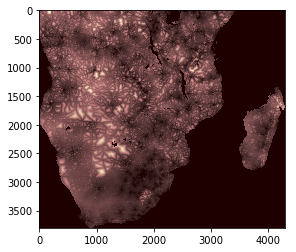

val_prod


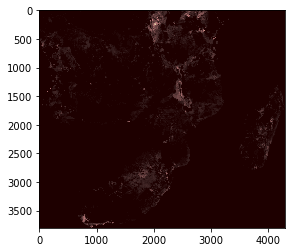

val_prod_per_ha


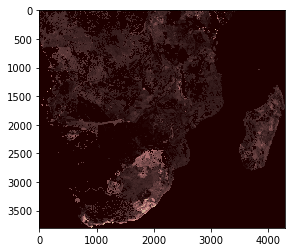

night_lights


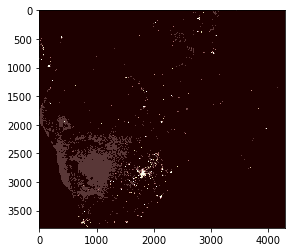

In [477]:
for name in pca_data_names:
    print(name)
    pyplot.imshow(pca_data.loc[name,'processed'].read(1), cmap='pink')
    pyplot.savefig(name+'_proc.png')
    pyplot.show()

## Create PCA dataframe

Merge all PCA variables into one dataframe with full coordinates as index

In [478]:
# Define functions for reshaping banded data df into PCA format
def pca_melt(dataset_name):
    # preps the dataframe to be melted by adding columns for x and y
    df = pca_data.loc[dataset_name,'cleaned_df']
    
    # argument: dataframe with x coord as index as y coords as columns
    nrows, ncols = df.shape
    nrows -= 1; ncols -= 1

    # convert index to a column to melt
    re_df = df.reset_index().rename(columns={'index':'x'})
    re_df = pd.melt(re_df, id_vars=['x'],
                    value_vars=range(0,ncols),
                    var_name='y',
                    value_name = dataset_name)
    
    # turn x and y columns into a coordinate index
    re_df['coords'] = re_df['x'].astype(str)+','+re_df['y'].astype(str)
    re_df = re_df.set_index('coords')
    
    return re_df

def save_coord_ranges(coord_ranges_dataframe,pca_df,dataset_name):
    # ARGS: dataframe with rows min x, max y, min y, max y,
        # melted dataframe for PCA with columns labeled 'x' and 'y'
    # adds a column to coord_ranges with info for the given pca dataframe
    coord_ranges_dataframe[dataset_name]=[min(pca_df['x']),
                                     max(pca_df['x']),
                                     min(pca_df['y']),
                                     max(pca_df['y'])]
    
    return coord_ranges

def check_pca_reshape(re_df, n=15):
    # check that the raw and reshaped dfs have the same values 
    # for a random set of n coordinates
    df = pca_data.loc[dataset_name,'cleaned_df']
    check = True
    for i in range(0,n):
        x = randint(0, df.shape[0]-1); y = randint(0, df.shape[1]-1)
        raw_val = df.loc[x][y]
        new_val = re_df.loc[str(x)+','+str(y)][dataset_name]
        if (raw_val != new_val) & (not math.isnan(new_val)):
            check = False
            print('Error for coordinate: (',x,',',y,
                  ')\nraw:',raw_val,'\nnew:',new_val)
    return check

Process all of the datasets for PCA using the functions defined above:

In [479]:
pca_dfs = list()

# create dataframe to save coordinate ranges
coord_ranges = pd.DataFrame(index=['minx','maxx','miny','maxy'])

# iterate through datasets and reshape for PCA
for dataset_name in pca_data_names:
    # melt dataframe
    pca_df = pca_melt(dataset_name)
    # save the coordinate ranges
    coord_ranges = save_coord_ranges(coord_ranges, pca_df, dataset_name)
    # check that the resulting dataframe is correct
    check = check_pca_reshape(pca_df)
    if not check:
        print('Error in PCA reshape')
    # add the pca dataframe to the list
    pca_dfs.append(pca_df)

pca_data['pca_df'] = pca_dfs

In [480]:
coord_ranges

,travel_time,val_prod,val_prod_per_ha,night_lights
minx,0,0,0,0
maxx,3800,3800,3800,3800
miny,0,0,0,0
maxy,4296,4296,4296,4296


In [481]:
# check that it worked
name = 'travel_time'
pca_data.loc[name,'pca_df'].loc['0,1':'4,1']

,x,y,travel_time
coords,,,
"0,1",0,1,1.576670
"1,1",1,1,1.466540
"2,1",2,1,1.360971
"3,1",3,1,1.240261
"4,1",4,1,1.100291


In [482]:
pca_data.loc[name,'cleaned_df'].loc[0:4,[1]]

,1
0,1.576670
1,1.466540
2,1.360971
3,1.240261
4,1.100291


#### Use the x and y coordinate columns to crop datasets to same shape

In [483]:
# determine minimum and maximum for x and y
all_minx = max(coord_ranges.loc['minx'])
all_maxx = min(coord_ranges.loc['maxx'])
all_miny = max(coord_ranges.loc['miny'])
all_maxy = min(coord_ranges.loc['maxy'])

print('x range:',all_minx,all_maxx,
      '\ny range:',all_miny,all_maxy)

if (all_minx != 0) | (all_miny != 0):
    warnings.warn('One of the minimum coordinates is not zero')

x range: 0 3800 
y range: 0 4296


In [484]:
# crop all datasets
new_coord_ranges = pd.DataFrame(index=['minx','maxx','miny','maxy'])
cropped_pca_dfs = list()

for name in pca_data_names:
    df = pca_data.loc[name,'pca_df']
    df = df[(df['x']<=all_maxx) & (df['y']<=all_maxy)]
    new_coord_ranges = save_coord_ranges(coord_ranges, df, name)
    cropped_pca_dfs.append(df)

pca_data['cropped_pca_df'] = cropped_pca_dfs

In [485]:
new_coord_ranges

,travel_time,val_prod,val_prod_per_ha,night_lights
minx,0,0,0,0
maxx,3800,3800,3800,3800
miny,0,0,0,0
maxy,4296,4296,4296,4296


#### Merge individual dataframes into one PCA dataset

In [486]:
all_pca_data=pd.DataFrame()
for name in pca_data_names:
    df = pca_data.loc[name,'cropped_pca_df'][[name]]
    all_pca_data=all_pca_data.merge(df,how='outer',
                                    left_index=True,right_index=True,
                                   validate='one_to_one')

In [487]:
all_pca_data.describe(percentiles = [.2, .4, .5, .6, .8])

,travel_time,val_prod,val_prod_per_ha,night_lights
count,1.633290e+07,1.633290e+07,1.633290e+07,1.633290e+07
mean,5.860964e-03,-5.183216e-03,4.225111e-03,9.773845e-02
std,1.020539e+00,9.806183e-01,9.579259e-01,6.932629e-01
min,-7.696148e-01,-2.345577e-01,-4.097143e-01,0.000000e+00
20%,-7.696148e-01,-2.345577e-01,-4.097143e-01,0.000000e+00
40%,-6.499518e-01,-2.345577e-01,-4.097143e-01,0.000000e+00
50%,-3.010688e-01,-2.345577e-01,-4.097143e-01,0.000000e+00
60%,-4.613534e-02,-2.345577e-01,-4.097143e-01,0.000000e+00
80%,6.084939e-01,-7.529028e-02,2.875826e-01,0.000000e+00
max,9.661844e+00,6.316916e+01,2.791765e+01,1.400000e+01


In [488]:
name='val_prod_per_ha'
pca_data.loc[name,'cropped_pca_df'].loc['0,1':'5,1']

,x,y,val_prod_per_ha
coords,,,
"0,1",0,1,0.514605
"1,1",1,1,0.514605
"2,1",2,1,0.515304
"3,1",3,1,0.517728
"4,1",4,1,0.519916
"5,1",5,1,0.521901


In [489]:
all_pca_data.shape

(16332897, 4)

## Conduct PCA

Normalize the values in the PCA dataframe

In [490]:
# remove all rows with NA data
all_pca_data = all_pca_data.dropna(axis=0)
print(all_pca_data.shape)
coords_included = all_pca_data.index.tolist()
# FLAG: visualize all of the coordinates still included. what's the best 
# format for me to save them in for them to be visualized?
all_pca_data.head()

(16332897, 4)


,travel_time,val_prod,val_prod_per_ha,night_lights
coords,,,,
"0,0",1.579053,-0.220276,0.514605,0
"1,0",1.460457,-0.220276,0.514605,0
"2,0",1.349470,-0.215920,0.516304,0
"3,0",1.225867,-0.200388,0.522364,0
"4,0",1.084821,-0.185775,0.528065,0


In [491]:
# normalize columns of the dataframe
pca_matrix = np.matrix(all_pca_data)
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(pca_matrix)
all_pca_data_norm = scaler.transform(pca_matrix)

all_pca_data_norm[0:5]

array([[ 1.5788102 , -0.2203056 ,  0.5144641 , -0.14098275],
       [ 1.4602189 , -0.2203056 ,  0.5144641 , -0.14098275],
       [ 1.3492366 , -0.21595025,  0.51616323, -0.14098275],
       [ 1.2256396 , -0.20042019,  0.522222  , -0.14098275],
       [ 1.084599  , -0.1858086 ,  0.52792245, -0.14098275]],
      dtype=float32)

Perform PCA calculation

In [492]:
u,s,vt = np.linalg.svd(all_pca_data_norm, full_matrices=False)

In [493]:
pca_matrix = pd.DataFrame(u*s)
pca_matrix.head()

,0,1,2,3
0,0.155347,1.453032,0.775858,0.297213
1,0.155566,1.343777,0.732785,0.313706
2,0.159852,1.240821,0.693592,0.327285
3,0.174636,1.124416,0.652682,0.337861
4,0.188591,0.992091,0.605201,0.351253


In [494]:
# Set the index of the PCA results matrix to the lat-long coordinate pairs
pca_matrix.set_index(all_pca_data.index.values, inplace = True)
pca_matrix.head()

,0,1,2,3
"0,0",0.155347,1.453032,0.775858,0.297213
"1,0",0.155566,1.343777,0.732785,0.313706
"2,0",0.159852,1.240821,0.693592,0.327285
"3,0",0.174636,1.124416,0.652682,0.337861
"4,0",0.188591,0.992091,0.605201,0.351253


### Convert back to lat-long coordinate matrix

In [495]:
# create list of x and y values
x_coords = [int(ind.split(',')[0]) 
            for ind in list(pca_matrix.index)]
y_coords = [int(ind.split(',')[1]) 
            for ind in list(pca_matrix.index)]

In [496]:
# check that it worked
print(list(pca_matrix.index)[3800:3810])
print(y_coords[3800:3810])
print(x_coords[3800:3810])

['3800,0', '0,1', '1,1', '2,1', '3,1', '4,1', '5,1', '6,1', '7,1', '8,1']
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3800, 0, 1, 2, 3, 4, 5, 6, 7, 8]


In [497]:
# add x and y values as columns of dataframe
pca_matrix['x'] = x_coords
pca_matrix['y'] = y_coords
print(pca_matrix.dtypes)
pca_matrix.head()

0    float32
1    float32
2    float32
3    float32
x      int64
y      int64
dtype: object


,0,1,2,3,x,y
"0,0",0.155347,1.453032,0.775858,0.297213,0,0
"1,0",0.155566,1.343777,0.732785,0.313706,1,0
"2,0",0.159852,1.240821,0.693592,0.327285,2,0
"3,0",0.174636,1.124416,0.652682,0.337861,3,0
"4,0",0.188591,0.992091,0.605201,0.351253,4,0


In [498]:
# create list for reshaped lat_long matrix
latlon_pcas = []

# iterate through pcas and save reshaped lat_long matrix
for pca_num in range(pca_matrix.shape[1]-2):
    # take appropriate subset of pca_matrix
    df = pca_matrix[[pca_num,'x','y']]    
    # reshape using pivot
    df = (df.pivot(index='x',columns='y')[pca_num])
    # remove row and column names
    df.columns.name = None
    df.index.name = None
    latlon_pcas.append(df)

In [499]:
# see PCA 1
latlon_pcas[0].head()

,0,1,2,3,4,5,6,7,8,9,...,4287,4288,4289,4290,4291,4292,4293,4294,4295,4296
0,0.155347,0.155351,0.155361,-0.480189,-0.480159,-0.480115,-0.480054,-0.479974,-0.479866,-0.479721,...,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888
1,0.155566,0.155554,0.155548,-0.480019,-0.480005,-0.479977,-0.479931,-0.479865,-0.479769,-0.479637,...,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888
2,0.159852,0.159289,0.158531,-0.479845,-0.479843,-0.479826,-0.479791,-0.479736,-0.479651,-0.479531,...,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888
3,0.174636,0.171789,0.168102,-0.479635,-0.479639,-0.479630,-0.479604,-0.479557,-0.479483,-0.479376,...,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888
4,0.188591,0.183131,0.176359,-0.479382,-0.479391,-0.479387,-0.479367,-0.479329,-0.479265,-0.479172,...,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888,-0.475888


## Create raster map of each PCA

Write raster files for each PCA

In [500]:
raster_pca_paths = []
for pca_num in range(len(latlon_pcas)):
    raster_pca_paths.append('results/raster_pca'+str(pca_num+1)+'.tif')
raster_pca_paths

['results/raster_pca1.tif',
 'results/raster_pca2.tif',
 'results/raster_pca3.tif',
 'results/raster_pca4.tif']

In [501]:
for pca_num in range(len(latlon_pcas)):
    with fiona.open("data/raw_data/border_box.shp", "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform,
                     "dtype": 'float32'})
 
    with rasterio.open(raster_pca_paths[pca_num],
                       'w', **out_meta) as dst:
        dst.write(np.array(latlon_pcas[pca_num]), 1)

In [502]:
# create a list of processed pca rasters
pca_rasters = list()
for pca_num in range(len(latlon_pcas)):
    pca_rasters.append(rasterio.open(raster_pca_paths[pca_num]))

PCA 1


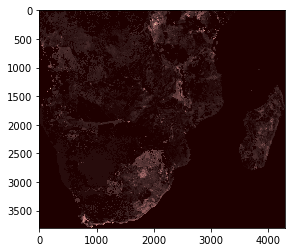

PCA 2


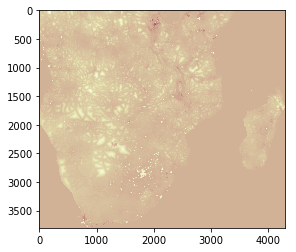

PCA 3


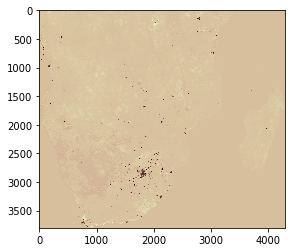

PCA 4


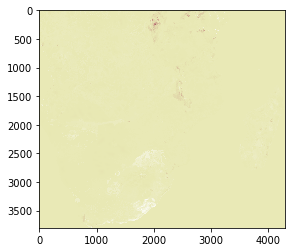

In [503]:
# show raster images and export as png files
for pca_num in range(len(latlon_pcas)):
    print('PCA '+str(pca_num+1))
    pyplot.imshow(pca_rasters[pca_num].read(1), cmap='pink')
    pyplot.savefig('results/raster_pca'+str(pca_num+1)+'.png')
    pyplot.show()

## Analyze PCA Results

In [504]:
def variance_captured(s, i):
    # returns the proportion of variance captured by pc i
    return s[i-1]**2 / np.sum(s**2)

def variance_captured_first_k(s, k):
    # returns the proportion of variance captured by pcs 1 through k
    return sum([variance_captured(s, ki) for ki in range(1, k+1)])

Scree plot

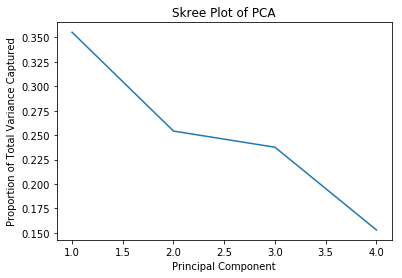

In [505]:
x = np.arange(1,all_pca_data.shape[1]+1)
var = [variance_captured(s, xi) for xi in x]
plt.plot(x, var);
plt.xlabel('Principal Component');
plt.ylabel('Proportion of Total Variance Captured');
plt.title('Skree Plot of PCA');

In [506]:
print('Number of PCs\tVariance captured')
for i in range(1, all_pca_data.shape[1]+1):
    print(i,'\t\t',round(variance_captured_first_k(s,i),4))

Number of PCs	Variance captured
1 		 0.3553
2 		 0.6094
3 		 0.847
4 		 1.0


Examine the weights of the PCs

In [507]:
weights = pd.DataFrame({'Var':all_pca_data.columns,
                       'PC1 weights':np.array(vt[0,:]),
                       'PC2 weights':np.array(vt[1,:])
                       }).set_index('Var')
weights.sort_values('PC1 weights')

,PC1 weights,PC2 weights
Var,,
travel_time,-0.001845,0.921268
night_lights,0.297235,0.348745
val_prod,0.673013,-0.171066
val_prod_per_ha,0.677275,0.019446


In [508]:
def plot_pc(col_names, vt, k):
    plt.bar(col_names, vt[k, :], alpha=0.7)
    plt.xticks(col_names, rotation=90)
    plt.title('PC ' + str(k+1) + ' Loadings');

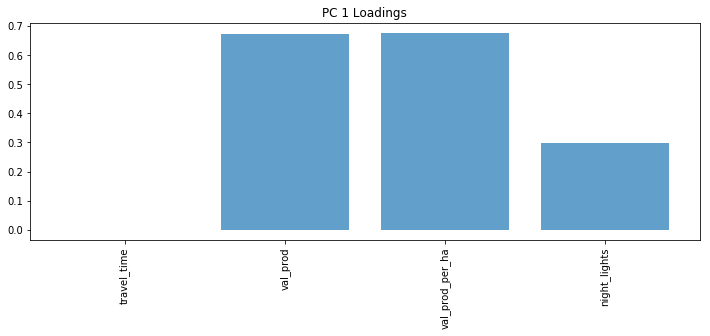

In [509]:
with plt.rc_context({"figure.figsize": (12, 4)}):
    plot_pc(list(all_pca_data.columns), vt, 0);

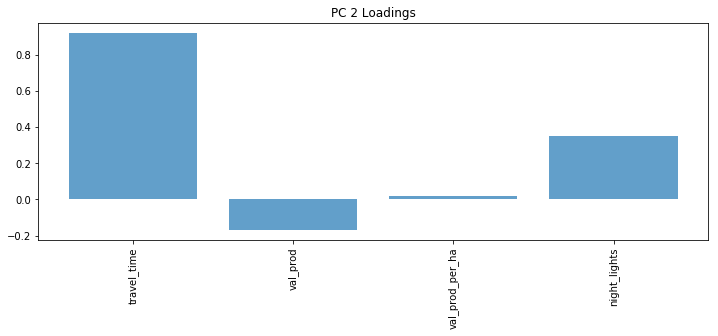

In [510]:
with plt.rc_context({"figure.figsize": (12, 4)}):
    plot_pc(list(all_pca_data.columns), vt, 1);

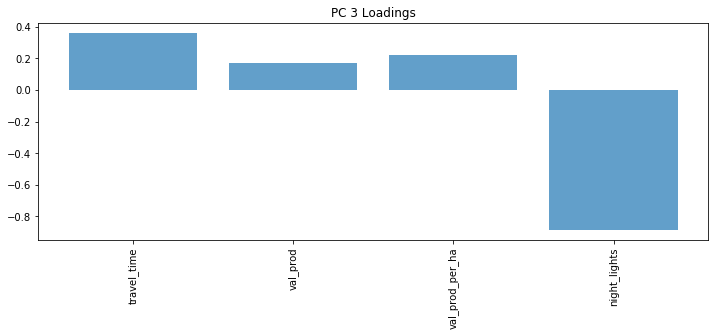

In [511]:
with plt.rc_context({"figure.figsize": (12, 4)}):
    plot_pc(list(all_pca_data.columns), vt, 2);

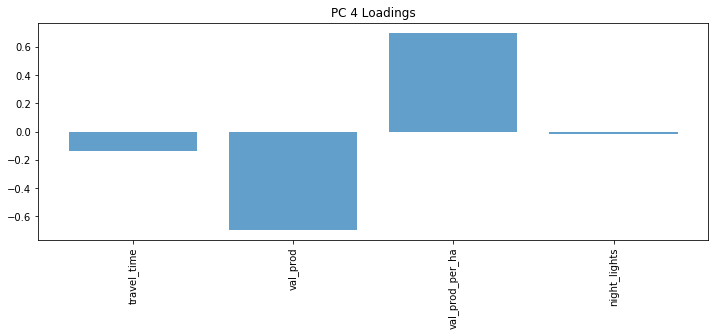

In [512]:
with plt.rc_context({"figure.figsize": (12, 4)}):
    plot_pc(list(all_pca_data.columns), vt, 3);

In [306]:
first_2_pcs = pd.DataFrame((u*s)[:, 0:2], columns = ["pc1", "pc2"]) # SOLUTION
sns.scatterplot(data = first_2_pcs.sample(n=1000), x = "pc1", y = "pc2").set_title('Scatterplot of PC1 by PC2')

AttributeError: module 'seaborn' has no attribute 'scatterplot'